In [1]:
import numpy as np
import pandas as pd
import os       
import math
import random
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns
from phmm import PHMM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format = True)
df = df.set_index(["Date"])
df = df.loc[:,['Open']]
df = df.iloc[::-1,:]
df.head()

,Open
Date,
2013-10-08,157.00
2013-10-09,155.70
2013-10-10,156.00
2013-10-11,161.15
2013-10-14,160.85


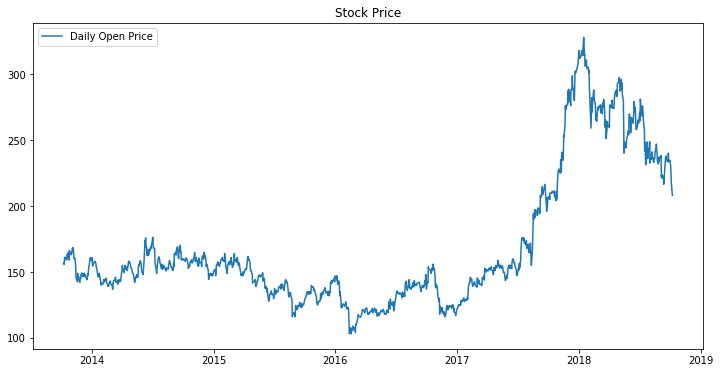

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df, label='Daily Open Price')
plt.title('Stock Price')
plt.legend()
plt.show()

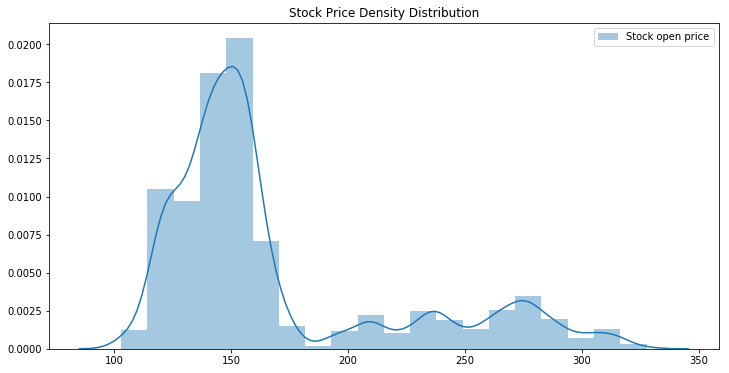

In [4]:
plt.figure(figsize=(12,6))
sns.distplot(df, bins=20, label='Stock open price')
plt.title('Stock Price Density Distribution')
plt.legend()
plt.show()

In [5]:
class HMM:    
    def __init__(self, K, transition_matrix, observation_mean, observation_std, initial_state): 
        self.K = int(K)
        self.A = transition_matrix  
        self.mean = observation_mean
        self.std = observation_std
        self.pi = initial_state
    
    def forward(self, X):
        self.alpha = np.zeros((len(X), self.K))
        self.C = np.zeros(len(X))
        for k in range(self.K):
            self.alpha[0][k] = self.pi[k] * self.prob(X[0], self.mean[k], self.std[k])
        self.C[0] = sum(self.alpha[0])
        self.alpha[0] /= self.C[0]
        for t in range(1, len(X)):
            for k in range(self.K):
                self.alpha[t][k] = sum([self.alpha[t-1][k0] * self.A[k0][k] 
                                        * self.prob(X[t], self.mean[k], self.std[k]) for k0 in range(self.K)])
            self.C[t] = sum(self.alpha[t])
            self.alpha[t] /= self.C[t]
    
    def backward(self, X):
        self.beta = np.ones((len(X), self.K))
        for t in range(len(X)-2, -1, -1):
            for k in range(self.K):
                self.beta[t][k] = sum([self.beta[t+1][k0] * self.A[k][k0]
                                       * self.prob(X[t+1], self.mean[k0], self.std[k0]) for k0 in range(self.K)])
            self.beta[t] /= self.C[t+1]
    
    def EM(self, X, num_iter=100):
        for i in tqdm(range(num_iter)):
            self.forward(X)
            self.backward(X)
            gamma = self.alpha * self.beta
            xi = np.zeros((len(X), self.K, self.K))
            for t in range(len(X)-1):
                for j in range(self.K):
                    for k in range(self.K):
                        xi[t][j][k] = ((self.alpha[t][j] * self.A[j][k] * self.prob(X[t+1],self.mean[k],self.std[k])
                                       * self.beta[t+1][k]) / self.C[t+1])
            self.pi = [gamma[0][k]/sum(gamma[0]) for k in range(self.K)]
            
            for j in range(self.K):
                for k in range(self.K):
                    self.A[j][k] = sum(xi[:,j,k]) / sum([sum(xi[:,j,l]) for l in range(self.K)])
            
            for k in range(self.K):
                self.mean[k] = sum(X*gamma[:,k]) / sum(gamma[:,k])
                self.std[k] = np.sqrt(sum(X*X*gamma[:,k]) / sum(gamma[:,k]) - self.mean[k]**2)
                
    def prob(self, x, mean, std):
        return np.exp(-0.5*(mean-x)**2/std**2)/np.sqrt(2*np.pi*std**2)
    
    def best_states_seq(self, x):
        z = []
        V = np.zeros((len(x), self.K) ) - 10**5
        best_states = np.zeros((len(x), self.K))

        for n in range(len(x)):
            for j in range(self.K):
                if n == 0:
                    V[n,j] = np.log(self.prob(x[n], self.mean[j], self.std[j])) + np.log(self.pi[j]+1e-5)
                    best_states[n,j] = -1
                else:
                    for i in range(self.K):
                        prob = np.log(self.prob(x[n], self.mean[j], self.std[j])) + V[n-1, i] + np.log(self.A[i, j])
                        if prob > V[n,j]:
                            V[n,j] = prob
                            best_states[n,j] = i
          
        index = int(np.where(V[-1,:]==max(V[-1,:]))[0])
        z.append(index)
        for n in range(1, len(x)):
            index = int(best_states[-n, index])
            z.append(index)
        return z[::-1]
    
    def sample_by_states(self, Z, seed=None):
        if seed:
            np.random.seed(seed)
        obs = []
        for z in Z:
            obs.append(np.random.normal(self.mean[z], self.std[z]))
        return obs

In [6]:
def runHMM(train, valid, K, num_iter=1000, seed=1):
    x_train = np.array(train).reshape(-1)
    x_valid = np.array(valid).reshape(-1)
    A = np.random.randint(1,10,size = [K,K])
    transition_matrix = np.array([a/sum(a) for a in A])
    observation_mean = np.ones(K)*np.mean(x_train)
    observation_std = np.ones(K)*np.std(x_train)
    initial_states = A[1]/sum(A[1])
    
    hmm = HMM(K, transition_matrix, observation_mean, observation_std, initial_states)
    
    hmm.EM(x_train, num_iter)
    
    pred_hidden = hmm.best_states_seq(x_valid)
    pred_obs = hmm.sample_by_states(pred_hidden, seed=seed)
    bias = np.mean(pred_obs - x_valid)
    smape = np.mean(2*np.abs(pred_obs-x_valid)/(np.abs(pred_obs)+np.abs(x_valid)))
    rmse = np.sqrt(np.mean((pred_obs-x_valid)**2))
    
    return ([hmm, pred_hidden, pred_obs], [smape, bias, rmse])

In [7]:
def runPHMM(train, valid, K, num_iter=1000, seed=1):
    
    def poi_sample_by_states(Z, seed=None):
        if seed:
            np.random.seed(seed)
        obs = []
        for z in Z:
            obs.append(np.random.poisson(hmm.lambdas[z]))
        return obs

    x_train = np.array(train).reshape(-1)
    x_valid = np.array(valid).reshape(-1)
    x_train = [[int(i) for i in x_train]]
    
    A = np.random.randint(1,10,size = [K,K])
    theta = np.array([a/sum(a) for a in A])
    lambdas = A[0]
    delta = A[1]/sum(A[1])

    hmm = PHMM(delta, theta, lambdas)
    hmm.baum_welch(x_train, max_iter=num_iter)
    states = hmm.viterbi([int(i) for i in x_valid])
    pred_obs = poi_sample_by_states(states, seed=seed)
    
    bias = np.mean(pred_obs - x_valid)
    smape = np.mean(2*np.abs(pred_obs-x_valid)/(np.abs(pred_obs)+np.abs(x_valid)))
    rmse = np.sqrt(np.mean((pred_obs-x_valid)**2))
    
    return ([hmm, states, pred_obs], [smape, bias, rmse])

In [8]:
train = df[:int(0.8*len(df))]
valid = df[int(0.8*len(df)):int(0.9*len(df))]
test = df[int(0.9*len(df)):]

In [9]:
K_range = [2,4,6,8]
table = []
best_model = 0
best_mape = 1
for K in K_range:
    print('Training for K = {}'.format(K))
    result = runHMM(train, valid, K, num_iter=500)
    table.append(result[1])
    if result[1][0] < best_mape:
        best_model = result[0]

  0%|          | 1/500 [00:00<01:07,  7.38it/s]

Training for K = 2


  0%|          | 0/500 [00:00<?, ?it/s]

Training for K = 4


  0%|          | 0/500 [00:00<?, ?it/s]

Training for K = 6


  0%|          | 0/500 [00:00<?, ?it/s]

Training for K = 8


100%|██████████| 500/500 [10:47<00:00,  1.29s/it]


In [10]:
pd.DataFrame(table, columns=['SMAPE', 'BIAS', 'RMSE'], index=['K=2', 'K=4', 'K=6', 'K=8'])

,SMAPE,BIAS,RMSE
K=2,0.515965,-112.387519,116.976286
K=4,0.398156,-91.138245,97.001906
K=6,0.396330,-90.796701,96.679265
K=8,0.282691,-68.554453,75.495227


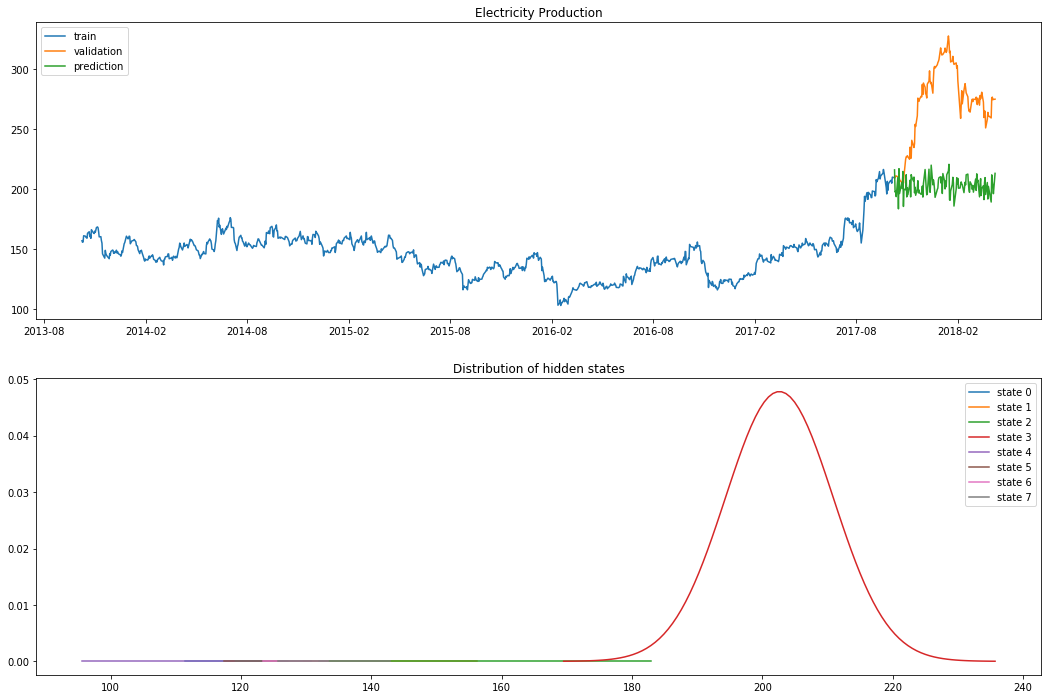

In [13]:
valid['pred'] = best_model[2]
hmm = best_model[0]
Z = best_model[1]
plt.figure(figsize=(18,12))
plt.subplot(2,1,1)
plt.plot(train, label = 'train')
plt.plot(valid.Open, label = 'validation')
plt.plot(valid.pred, label='prediction')
plt.legend()
plt.title('Electricity Production')

def plot_pdf(mean, std, frac, label):
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    plt.plot(x, frac*stats.norm.pdf(x, mean, std), label=label)

plt.subplot(2,1,2)
for k in range(8):
    plot_pdf(hmm.mean[k], hmm.std[k], Z.count(k)/len(test), 'state {}'.format(k))
plt.legend()
plt.title('Distribution of hidden states')
plt.show()
